# Python 3.6
# Pytorch

In [1]:
import torch
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
import pickle

In [2]:
class Loader:
    
    def unpickle(self,file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict
    
    def load_train_data(self):
        '''
        loads training data: 50,000 examples with 3072 features
        '''
        X_train = None
        Y_train = None
        for i in range(1, 6):
            pickleFile = self.unpickle('cifar-10-batches-py/data_batch_{}'.format(i))
            dataX = pickleFile[b'data']
            dataY = pickleFile[b'labels']
            if type(X_train) is np.ndarray:
                X_train = np.concatenate((X_train, dataX))
                Y_train = np.concatenate((Y_train, dataY))
            else:
                X_train = dataX
                Y_train = dataY

        Y_train = Y_train.reshape(Y_train.shape[0], 1)

        return X_train, Y_train

    def load_test_data(self):
        '''
        loads testing data: 10,000 examples with 3072 features
        '''
        X_test = None
        Y_test = None
        pickleFile = self.unpickle('cifar-10-batches-py/test_batch')
        dataX = pickleFile[b'data']
        dataY = pickleFile[b'labels']
        if type(X_test) is np.ndarray:
            X_test = np.concatenate((X_test, dataX))
            Y_test = np.concatenate((Y_test, dataY))
        else:
            X_test = np.array(dataX)
            Y_test = np.array(dataY)

        Y_test = Y_test.reshape(Y_test.shape[0], 1)

        return X_test, Y_test

In [3]:
# split data
X_trainval,Y_trainval = Loader().load_train_data()
X_test, Y_test = Loader().load_test_data()

X_trainval = X_trainval.astype(float)
X_trainval_scale = X_trainval / 255

X_test = X_test.astype(float)
X_test_scale = X_test / 255

X_trainval_reshape = X_trainval_scale.reshape((X_trainval.shape[0],3,32,32))
X_test_reshape = X_test_scale.reshape((X_test.shape[0],3,32,32))


num_train = 50000
indices = list(range(num_train))
split = 40000
np.random.shuffle(indices)

valid_idx, train_idx = indices[split:], indices[:split]

X_train_reshape = X_trainval_reshape[train_idx]
Y_train_reshape = Y_trainval[train_idx]

X_val_reshape = X_trainval_reshape[valid_idx]
Y_val_reshape = Y_trainval[valid_idx]



In [4]:
import torch.utils.data as data_utils

train_try = data_utils.TensorDataset(torch.FloatTensor(X_train_reshape), torch.LongTensor(Y_train_reshape.reshape(40000)))
train_try_loader = data_utils.DataLoader(train_try, batch_size=4, shuffle=True)

In [179]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 192, 5,padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(192, 160, 3,padding=2)
        
        self.conv3 = nn.Conv2d(160,96,3,padding=2)
        
        #self.conv4 = nn.Conv2d(72,168,3,padding=2)


        self.fc1 = nn.Linear(96*5*5,120)
        self.fc2 = nn.Linear(120,96)
        self.fc3 = nn.Linear(96,10)

        
        
        self.bn1 = nn.BatchNorm2d(192)
        self.bn2 = nn.BatchNorm2d(160)
        self.bn3 = nn.BatchNorm2d(96)
        #self.bn4 = nn.BatchNorm2d(168)
        
        self.drop = nn.Dropout2d(p=0.5)
        

    def forward(self, x):
        #print(self.conv1(x).shape)
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        #print(x.shape)

        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        #x = self.drop(self.pool(F.relu(self.conv2(x))))
        
        x = self.pool(self.bn3(F.relu(self.conv3(x))))
        
        #x = self.pool(self.bn4(F.relu(self.conv4(x))))
        #x = self.drop(self.pool(F.relu(self.conv3(x))))
        #print(x.shape)
        
        
        x = x.view(-1,96*5*5)

        x = (F.relu(self.fc1(x)))
        x = (F.relu(self.fc2(x)))
        x = (self.fc3(x))
        
        #x = self.softmax(x)
        return x
    
net_2 = Net()

import torch.optim as optim
from random import randint
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_2.parameters(), lr=0.001, momentum=0.9,weight_decay=0.0005)

In [180]:
temp_lr = 0.001
prev_acc = 0


best_net_2 = Net()
train_loss_2 = []
validation_acc_2 = []
best_acc_2 = 0

decrease = 0

for epoch in range(10):  # loop over the dataset multiple times
    if epoch > 0:
        if (prev_acc / acc > 0.995):
            temp_lr /= 5
        prev_acc = acc
        #prev_acc = acc
        #if (epoch % 10 == 0):
        #    temp_lr /= 4
    optimizer = optim.SGD(net_2.parameters(), lr=temp_lr, momentum=0.9,weight_decay=0.0005)
    #optimizer = optim.Adam(net_2.parameters(), lr=0.001)
    #temp_lr /= 5
    
    running_loss = 0.0
    
    train_correct = 0
    train_total = 0
    for batch_idx, (inputs, targets) in enumerate(train_try_loader):
        
        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        outputs = net_2(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        
        _, predicted_train = torch.max(outputs.data, 1)
        
        for i in range(4):
            if predicted_train[i] == int(targets[i].data.numpy()[0]):
                train_correct += 1
            train_total +=1

        # print statistics
        running_loss += loss.data[0]
        #print("Summary: %d is %.3f" % (epoch, acc))
        
    train_acc = train_correct / train_total
        
        
    correct = 0
    total = 0
    for i in range(0,10000):
        inputs = torch.FloatTensor(X_val_reshape[i].reshape((1,3,32,32)))
        labels = torch.LongTensor(Y_val_reshape[i])
        outputs = net_2(Variable(inputs))
        _, predicted = torch.max(outputs.data, 1)

        if predicted[0] == labels[0]:
            correct += 1
        total += 1
        
    acc = correct / total
    train_loss_2.append(running_loss/10000)
    validation_acc_2.append(acc)
    if (acc > best_acc_2):
        best_acc_2 = acc
        best_net_2.load_state_dict(net_2.state_dict())
    
    print("epoch: %d loss: %.3f train_acc: %.3f val_acc: %.3f learning rate: %.6f" % (epoch,running_loss/10000,train_acc,acc,temp_lr))

print('Finished Training')

epoch: 0 loss: 1.329 train_acc: 0.521 val_acc: 0.607 learning rate: 0.001000
epoch: 1 loss: 0.937 train_acc: 0.671 val_acc: 0.659 learning rate: 0.001000
epoch: 2 loss: 0.768 train_acc: 0.730 val_acc: 0.695 learning rate: 0.001000
epoch: 3 loss: 0.650 train_acc: 0.772 val_acc: 0.687 learning rate: 0.001000
epoch: 4 loss: 0.392 train_acc: 0.866 val_acc: 0.744 learning rate: 0.000200
epoch: 5 loss: 0.302 train_acc: 0.895 val_acc: 0.746 learning rate: 0.000200
epoch: 6 loss: 0.219 train_acc: 0.928 val_acc: 0.750 learning rate: 0.000040
epoch: 7 loss: 0.199 train_acc: 0.936 val_acc: 0.749 learning rate: 0.000040
epoch: 8 loss: 0.179 train_acc: 0.943 val_acc: 0.750 learning rate: 0.000008
epoch: 9 loss: 0.177 train_acc: 0.946 val_acc: 0.750 learning rate: 0.000002
Finished Training


In [181]:
correct = 0
total = 0
for i in range(0,10000):
    inputs = torch.FloatTensor(X_test_reshape[i].reshape((1,3,32,32)))
    labels = torch.LongTensor(Y_test[i])
    outputs = best_net_2(Variable(inputs))
    _, predicted = torch.max(outputs.data, 1)
    
    if predicted[0] == labels[0]:
        correct += 1
    total += 1

print(correct)
print(total)
print(correct/total)

7497
10000
0.7497


In [194]:
train_acc_2 = [0.521,0.671,0.73,0.772,0.866,0.895,0.928,0.936,0.943,0.946]

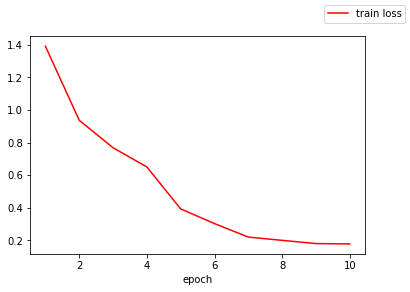

In [192]:
%matplotlib inline
import matplotlib.pyplot as plt

xAxis = [1,2,3,4,5,6,7,8,9,10]
fig,ax1 = plt.subplots()
ax1.plot(xAxis,train_loss_2,color ='red',label="train loss")
ax1.set_xlabel("epoch")
fig.legend()
plt.show()

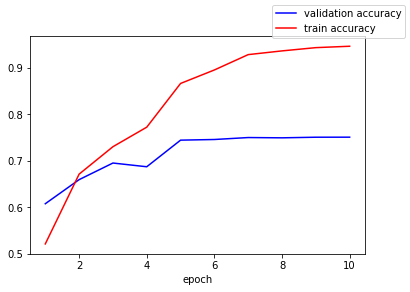

In [195]:
fig,ax1 = plt.subplots()
ax1.plot(xAxis,validation_acc_2,color ='blue',label="validation accuracy")
ax1.plot(xAxis,train_acc_2,color ='red',label="train accuracy")
ax1.set_xlabel("epoch")
fig.legend()
plt.show()